In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Load the data

### Real data

In [3]:
neural_data=np.loadtxt('superchris_odor_spike_mat.csv',delimiter=',',skiprows=1,usecols=range(5,51)) # first row is col names
odor_data = np.loadtxt('superchris_odor_spike_mat.csv',delimiter=',',skiprows=1,usecols=[1,4]) # odor, trial_id
print(neural_data.shape)
print(odor_data.shape)

(281329, 46)
(281329, 2)


### Fake data for VAE

In [5]:
fake_neural_data_vae = np.loadtxt('VAE_fake_data/Fake_Neural_Spike_Data.csv',delimiter=',',skiprows=0)
fake_odor_spec_data_vae = np.loadtxt('VAE_fake_data/Odor_specific_fake_data.csv',delimiter=',',skiprows=0)

print(fake_neural_data_vae.shape)
print(fake_odor_spec_data_vae.shape)

# get the odor label 
x = np.array([1,2,3,4,5])
fake_odor_label_vae = np.repeat(x, 200, axis=0)
fake_odor_label_vae.shape

(1000, 46)
(1000, 46)


(1000,)

### Fake data for LSTM_VAE

In [22]:
fake_neural_data_lstm_vae = np.load("LSTM_VAE_fake_data/LSTM_Fake_odor_specific.npy")
fake_odor_label_lstm_vae = np.load("LSTM_VAE_fake_data/LSTM_Fake_odor_specific_label.npy")
print(fake_neural_data_lstm_vae.shape)
print(fake_odor_label_lstm_vae.shape)

(50, 11, 46)
(50,)


## preprocess into firing rate

In [15]:
def bin_sum(data, bin_size):
    """
    Perform sliding window 1ms summation on each column of a 2D numpy array.
    
    Args:
        data (np.ndarray): 2D array where summation is applied column-wise.
        bin_size (int): Size of the sliding window.
        
    Returns:
        np.ndarray: 2D array with summed values for each column based on the sliding window.
    """
    if bin_size > data.shape[0]:
        raise ValueError("bin_size cannot be larger than the number of rows in the data.")
    
    # Calculate the number of rows in the output
    output_rows = data.shape[0] - bin_size + 1
    output = np.zeros((output_rows, data.shape[1]))
    
    # Perform sliding window summation
    for i in range(output_rows):
        output[i, :] = np.sum(data[i:i+bin_size, :], axis=0)
    
    return output

# Initialize lists to hold trial-wise batches
spike_data_list = []
odor_data_list = []
time_bin = 150
smooth = True
sigma = 5

# Iterate over trials
for i_trial in np.unique(odor_data[:, 1]):   
    # Extract the rows corresponding to the current trial
    neural_data_i_trial = neural_data[odor_data[:, 1] == i_trial]

    # # Perform sliding 1ms window for each entry
    # neural_bins_sum = bin_sum(neural_data_i_trial,bin_size)

    # Perform sum spike within bins
    remainder = neural_data_i_trial.shape[0] % time_bin
    if remainder != 0: 
        neural_bins_subset = neural_data_i_trial[:-remainder, :].reshape((-1, time_bin, 46))
    else: 
        neural_bins_subset = neural_data_i_trial.reshape((-1, time_bin, 46))

    # Sum the bins
    neural_bins_sum = np.sum(neural_bins_subset, axis=1)
    
    if smooth:
        neural_bins_sum = np.apply_along_axis(lambda col: gaussian_filter1d(col, sigma=sigma), axis=0, arr=neural_bins_sum)

    # Append spike data and labels for this trial
    spike_data_list.append(neural_bins_sum)
    odor_data_list.append(np.unique(odor_data[np.where(odor_data[:, 1] == i_trial), 0]))


# total number of trial
assert len(odor_data_list)==len(spike_data_list)
len(spike_data_list)

210

# Let's visualize first

In [16]:
def plot_psth(firing_rates, time_bins, num_neurons, cmap='viridis',title='PSTH'):
    """
    Plot a PSTH heatmap with time on the x-axis and neurons on the y-axis.

    Args:
        firing_rates (np.ndarray): Matrix of firing rates or spike counts with shape (num_neurons, num_time_bins).
        time_bins (np.ndarray): 1D array of time bin edges or centers for the x-axis (shape: [num_time_bins]).
        num_neurons (int): num of neurons for the y-axis.
        cmap (str): Colormap to use for the heatmap (default: 'viridis').
    """
    neuron_ids = range(0,num_neurons)
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the heatmap
    cax = ax.imshow(firing_rates, aspect='auto', cmap=cmap, extent=[time_bins[0], time_bins[-1], neuron_ids[-1], neuron_ids[0]])

    # Add labels and colorbar
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Neuron ID')
    ax.set_title(title)
    cbar = fig.colorbar(cax, ax=ax)
    cbar.set_label('Firing Rate (spk/s)')
    plt.show()

Real data

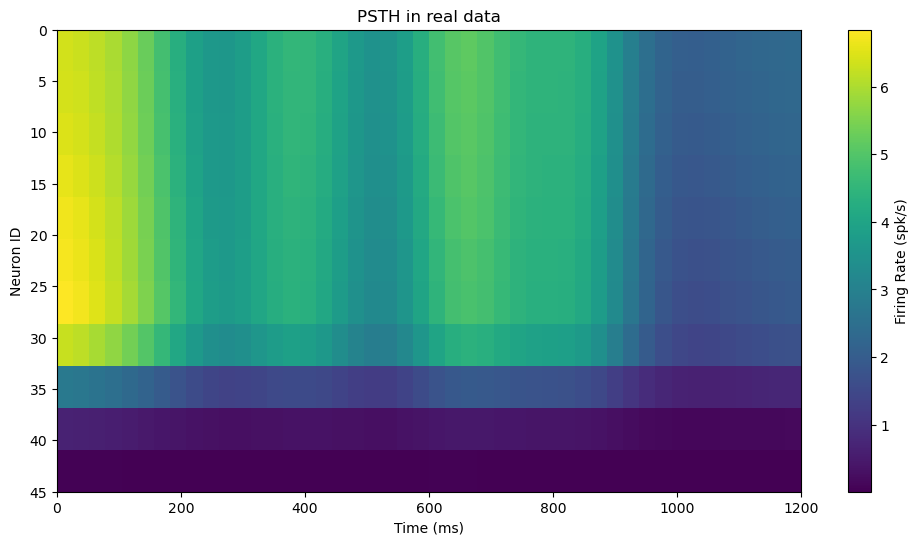

In [17]:
# Determine the maximum shape
max_rows = max(arr.shape[0] for arr in spike_data_list)
max_cols = max(arr.shape[1] for arr in spike_data_list)

# Pad arrays to the same size
padded_FR = [
    np.pad(arr, ((0, max_rows - arr.shape[0]), (0, max_cols - arr.shape[1])), mode='constant', constant_values=0)
    for arr in spike_data_list
]

# average over trials, unit: spk/s
real_firing_rate = 1e3*np.mean(padded_FR, axis=0)/150
smooth_real_firing_rate = gaussian_filter1d(real_firing_rate,sigma = 3,axis=1)

num_time_steps = real_firing_rate.shape[0]
time_bins = np.linspace(0, 1200, num_time_steps)  # Time bins from 0 to 1 s

plot_psth(smooth_real_firing_rate, time_bins, real_firing_rate.shape[1],title ='PSTH in real data')

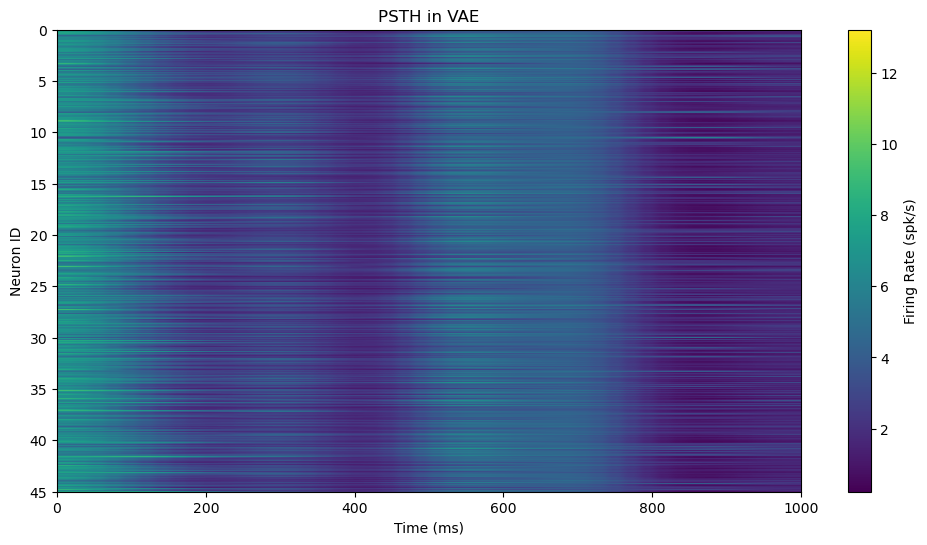

In [18]:
# Example data
num_neurons = 46
num_time_steps = 200
time_bins = np.linspace(0, 1000, num_time_steps)  # Time bins from 0 to 1 s

# firing rates 
firing_rates = fake_neural_data_vae * 1e3/150  # Firing rates between 0 and 50 Hz
smooth_firing_rate = gaussian_filter1d(firing_rates,sigma = 3,axis=1)

# Plot the PSTH
plot_psth(smooth_firing_rate, time_bins, num_neurons,title = 'PSTH in VAE')


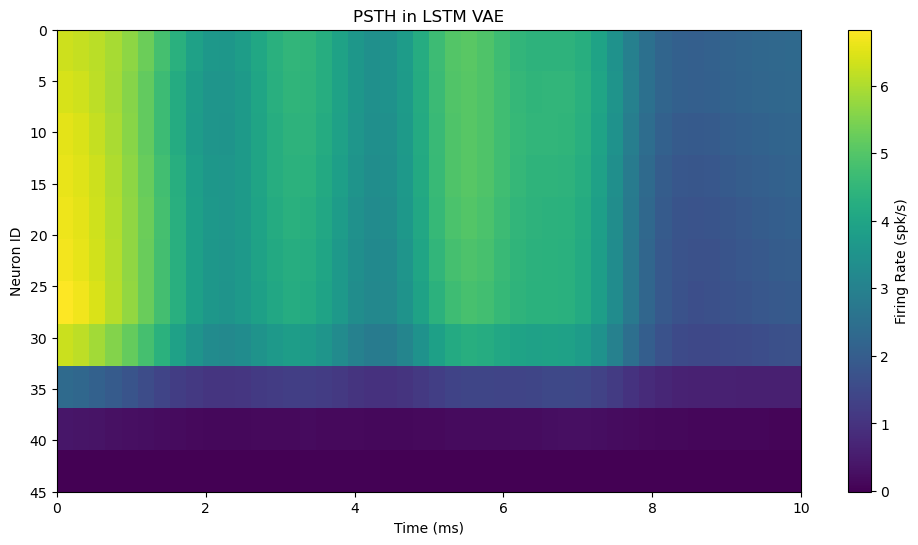

In [23]:
# Compute mean firing rate across trials
recon_FR = 1e3* np.mean(fake_neural_data_lstm_vae, axis=0)/150
smoothed_recon_FR = gaussian_filter1d(recon_FR, sigma=3, axis=1)

plot_psth(smoothed_recon_FR, time_bins = range(0, smoothed_recon_FR.shape[0]), num_neurons= 46, title = 'PSTH in LSTM VAE')

# Next, let's feed into classifier

In [ ]:
import torch
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
from sklearn.linear_model import LogisticRegression
from torch.utils.data import Dataset, DataLoader

# Define model and classifier
input_dim = 5  # Example input dimension
latent_dim = 2  # 2D latent space
num_classes = 3  # Example number of classes
hidden_size = 32
num_layers = 2

# Trained LSTMModel
model = LSTMModel(input_dim=input_dim, latent_dim=latent_dim, num_layers=num_layers, hidden_size=hidden_size)

# Example classifier
clf = LogisticRegression(max_iter = 2000, solver='lbfgs')

# Example dataset and DataLoader
sequences = [
    torch.rand(10, input_dim),  # Sequence 1
    torch.rand(15, input_dim),  # Sequence 2
    torch.rand(7, input_dim),   # Sequence 3
]
labels = torch.tensor([0, 1, 2])

# Create Dataset and DataLoader
class SequenceDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

dataset = SequenceDataset(sequences, labels)
data_loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=lambda x: x)

# Heatmap parameters
n = 30  # Grid size
scale = 1  # Latent space scale

# Run the heatmap visualization
latent_vectors = []
labels = []

# Encode data into latent space
with torch.no_grad():
    for batch in data_loader:
        sequences_batch, labels_batch = zip(*batch)
        lengths = torch.tensor([seq.size(0) for seq in sequences_batch])
        padded_sequences = pad_sequence(sequences_batch, batch_first=True)
        mean, _ = model.encode(padded_sequences, lengths=lengths)
        latent_vectors.append(mean)
        labels.append(torch.tensor(labels_batch))

# Concatenate latent vectors and labels
latent_vectors = torch.cat(latent_vectors, dim=0).numpy()
labels = torch.cat(labels).numpy()

if latent_dim > 2:
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    latent_vectors = pca.fit_transform(latent_vectors)

grid_x = np.linspace(-scale, scale, n)
grid_y = np.linspace(-scale, scale, n)[::-1]
latent_grid = torch.tensor([[xi, yi] for yi in grid_y for xi in grid_x]).float()

# train classifier
clf.fit(latent_vectors, labels)
latent_vectors.shape